In [7]:
# use OOT data to estimate bkg in signal region

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import make_datacard, make_datacard_2sig, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [8]:
def keyToyear(key):
    for year in years:
        if year in key:
            return year

# Load ntuples

In [20]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]
# mass = [15]
# VBFH = 0
# decay = 'dddd'

# mass = [7, 15, 40, 55]
# VBFH=1
# decay = 'bbbb'



VBFH = 0
decay = 'dddd' #no vbfh generated
# decay = '4Tau'
decay = 'bbbb'
# production = 'ttH_H'
# production = 'WplusH'
production = 'ggH'
mass = [15, 40, 55]
if not decay == 'bbbb': mass = [7, 15, 40, 55]
# mass = [15]
# ctau = [1, 10, 100, 1000, 10000, 100000]
# ctau = [10, 100, 1000, 10000, 100000]
OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

years = ['Summer16', 'Fall17', 'Fall18']
lumi = {
    'Summer16': 35.92 * 1000,
    'Fall17': 41.53 * 1000,
    'Fall18': 59.74 * 1000,
}
category = 0
ntupler_version = 'V1p17/'
analyzer_version = 'v1/v66/'

data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v66/normalized/'

fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
for m in mass:
    for ct in OLD_CTAU:
        key = 'MC_ggH_'+str(m)+'_'+str(ct)                       
        fpath[key] = mc_path+'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'
        if VBFH:
            key = 'MC_VBFH_'+str(m)+'_'+str(ct) 
            if decay == 'bbbb':
                fpath[key] = mc_path+'VBFH_HToSSTo4b_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'
            else:
                fpath[key] = mc_path+'VBFH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'


# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
           
# for m in mass:
#     for ct in OLD_CTAU:
#         key = 'MC_'+production+'_'+str(m)+'_'+str(ct)                       

#         fpath[key] = mc_path + production+'ToSS_SToBB_ms'+str(m)+'_pl'+str(ct)+'_137000pb_weighted.root'
#         print(fpath[key])
        
NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    w = tree[k]["weight"].array()
    if not 'data' in k: 
#         print(k, np.mean(tree[k]['gLLP_ctau'].array()))
        print(k,np.mean(w))
#         beta = tree[k]['gLLP_beta'].array()
#         gamma = 1.0/np.sqrt(1-beta*beta)
#         print(k,np.mean(tree[k]['gLLP_e'].array()/gamma))
#         print('acceptance', root_dir['acceptance'][1]/root_dir['NEvents'][1])
#         print('MET efficiency', root_dir['acceptance_met'][1]/root_dir['acceptance'][1])
#         print('product', root_dir['acceptance_met'][1]/root_dir['NEvents'][1])


        

MC_ggH_15_100 0.9734872
MC_ggH_15_1000 0.9854318
MC_ggH_15_10000 0.9453741
MC_ggH_15_100000 0.9571443
MC_ggH_40_100 0.9456105
MC_ggH_40_1000 0.9807466
MC_ggH_40_10000 0.96672267
MC_ggH_40_100000 0.908871
MC_ggH_55_100 0.9961474
MC_ggH_55_1000 0.97825044
MC_ggH_55_10000 0.9633573
MC_ggH_55_100000 0.9611651


# load bdt

In [10]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
# bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2'


# model = pickle.load(open( bdt_name+'.pickle', "rb" ))


# nCsc with different hit vetoing

In [21]:
%%time

start_t = time.time()
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50
cut_based = True
cut_based_version = 'v4'
# BDT_CUT = 0.467 #90% wp vBDT/v1, bdt_flatten_noEvtSelection
# bdtBkgEff =  0.0661076084960519

# BDT_CUT = 0.9227871 #90% wp vBDT/v2, bdt_flatten_metfilter_me1112nohits_eta2p1
# bdtBkgEff =  0.10278372591006424
if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
    BDT_CUT = 0.92245656 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs
    bdtBkgEff = 0.09957173447537473
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
    BDT_CUT = 0.9608465 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.06745182012847965
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2':
    BDT_CUT = 0.76344216 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.051208285385500575
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v5':
    BDT_CUT = 0.7802247 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.061027837259100645

elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12':
    BDT_CUT = 0.50882477 
    bdtBkgEff = 0.18136439267886856
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2':
    BDT_CUT = 0.2983932 
    bdtBkgEff = 0.34527687296416937
    BDT_BINS = [0.0, BDT_CUT]
#     BDT_BINS = [0.0, 0.1, 0.2, BDT_CUT]


else:
    print('BDT NAME NOT FOUND')
intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}
higgsPtWeight = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterXYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterAvgStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitClusterZSpread = {}
cscRechitClusterNStation10  = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterNChamber = {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
nCscRings = {}
nDtRings = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}
sf_facScaleUp = {}
sf_facScaleDown = {}
sf_renScaleUp = {}
sf_renScaleDown = {}
sf_facRenScaleUp = {}
sf_facRenScaleDown = {}
metSF = {}
legend = {}
runNum = {}
lumiSec = {}
evtNum = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'

# keys = ['data','mc_intime_bkg','mc_oot_bkg','mc_signal']
keys = ['data_intime','data_oot','mc_signal','mc_bkg']
keys = ['data_intime','mc_signal',]
keys = ['data_intime','mc_signal']
keys = ['data_oot_vr','data_oot_sr', 'data_intime_vr', 'data_intime_sr', 'mc_vr','mc_sr']
keys = ['data_oot_vr','data_oot_sr', 'data_intime_vr', 'data_intime_sr', 'mc100_vr','mc100_sr', 'mc1000_vr', 'mc1000_sr']
cluster_index = '3'


for k in list(tree.keys())+['data_oot_sr', 'data_oot_vr', 'data_intime_vr','data_intime_sr']:
#     if 'data' in k:continue
########### SELECTION: CLUSTERS ############
    if 'data' in k: T = tree['data']
    else: T = tree[k]

    sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
    
    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    
    if 'oot' in k:
        
        sel_rechitcluster = np.logical_and(sel_rechitcluster,  T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < -12.5)
    else:
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
    if 'MC' in k:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))


    print(np.count_nonzero(sel_rechitcluster.flatten()))

########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METNoMuTrigger')
#     sel_ev[k] = T.array('HLTDecision')[:,467]
#     sel_ev[k] = T.array('HLTDecision')[:,467]


    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') >= 200)
    sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == category)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)

    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    if 'MC' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)

    print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))
#     if np.count_nonzero(sel_ev[k]) == 0:continue
########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]


    ##### bdt variables ####
    
    ##### bdt variables ####
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    
    if len(cscRechitClusterAvgStation10[k])>0:
        
        if cut_based:     
            print("cut based", cut_based_version)
            if cut_based_version == 'v4':
                cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
                cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
                cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
                bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
            else:
                print("CUT BASED ERROR")
            if 'vr' in k:
                bdt_sel[k] = np.logical_not(bdt_sel[k])
                
        else:
            print('bdt based')
            if k == 'data_oot_sr':
                bdt_sel[k] = bdt_score[k] >= BDT_CUT
            elif 'vr' in k:
                bdt_sel[k] = bdt_score[k] < BDT_CUT            
            elif k == 'data':
                bdt_sel[k] = bdt_score[k] < BDT_CUT 
            else:
                bdt_sel[k] = bdt_score[k] >= BDT_CUT
        print("effiency",np.count_nonzero(bdt_sel[k])/len(bdt_sel[k]))

        dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()[bdt_sel[k]]
        jetMet_dPhiMin30[k] = T.array('jetMet_dPhiMin')[sel_ev[k]][bdt_sel[k]]
        if 'data' in k:metSF[k]= np.ones(dphiMet_cluster[k].shape, dtype=bool)
        else: metSF[k] = np.abs(T.array('metSF'))[sel_ev[k]][bdt_sel[k]]



        weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]][bdt_sel[k]]

        if 'data' in k:weight[k] = np.ones(weight[k].shape, dtype=bool)

            
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][bdt_sel[k]]
        nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]
        lumiSec[k] = T.array('lumiSec')[sel_ev[k]][bdt_sel[k]]
        runNum[k] = T.array('runNum')[sel_ev[k]][bdt_sel[k]]
        evtNum[k] = T.array('evtNum')[sel_ev[k]][bdt_sel[k]]




        
        
    else:
        dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight'))[sel_ev[k]]
        if 'data' in k:weight[k] = np.ones(weight[k].shape, dtype=bool)
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]]
        nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]
        if 'data' in k:metSF[k]= np.ones(dphiMet_cluster[k].shape, dtype=bool)
        else: metSF[k] = np.abs(T.array('metSF'))[sel_ev[k]]
        lumiSec[k] = T.array('lumiSec')[sel_ev[k]]
        runNum[k] = T.array('runNum')[sel_ev[k]]
        evtNum[k] = T.array('evtNum')[sel_ev[k]]
        print("no BDT applied")

949
data 1048070 531
cut based v4
effiency 0.2994350282485876
1011
MC_ggH_15_100 3446 957
cut based v4
effiency 0.845350052246604
3810
MC_ggH_15_1000 10282 3513
cut based v4
effiency 0.9148875604896101
1263
MC_ggH_15_10000 3729 1197
cut based v4
effiency 0.8930659983291562
153
MC_ggH_15_100000 507 148
cut based v4
effiency 0.918918918918919
32
MC_ggH_40_100 407 32
cut based v4
effiency 0.65625
2767
MC_ggH_40_1000 8544 2501
cut based v4
effiency 0.8876449420231908
2479
MC_ggH_40_10000 6750 2311
cut based v4
effiency 0.9216789268714842
333
MC_ggH_40_100000 1012 308
cut based v4
effiency 0.8863636363636364
0
MC_ggH_55_100 88 0
no BDT applied
1188
MC_ggH_55_1000 6691 1125
cut based v4
effiency 0.8204444444444444
2844
MC_ggH_55_10000 7262 2695
cut based v4
effiency 0.9209647495361781
467
MC_ggH_55_100000 1097 428
cut based v4
effiency 0.9392523364485982
2384
data_oot_sr 1048070 1519
cut based v4
effiency 0.3238973008558262
2384
data_oot_vr 1048070 1519
cut based v4
effiency 0.67610269914417

### Nrechit distribution for uncertainty calculation

In [13]:
Nrechits50 = 0
Nrechits130 = 0 
Nrechits250 = 0
for k in list(tree.keys()):
    if 'data' in k:continue
    if np.count_nonzero(sel_ev[k]) == 0: continue
    cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=50, nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<130)
    Nrechits50+= np.sum((pileupWeight[k] * weight[k] * higgsPtWeight[k])[cond])
    cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=130, nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<250)
    Nrechits130+= np.sum((pileupWeight[k] * weight[k] * higgsPtWeight[k])[cond])
    cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=250
    Nrechits250+= np.sum((pileupWeight[k] * weight[k] * higgsPtWeight[k])[cond])
print(Nrechits50, Nrechits130, Nrechits130/(Nrechits130+Nrechits250), Nrechits250/(Nrechits130+Nrechits250))

KeyError: 'MC_ggH_15_100'

/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cluster_eff_year2017_norm50_V1p17v28_tag_probe/
MC_ggH_15_100 -0.08450179101923105
MC_ggH_15_1000 -0.2116101578388152
MC_ggH_15_10000 -0.2322451972713786
MC_ggH_15_100000 -0.28110025076851464
MC_ggH_40_100 0.15772829152415024
MC_ggH_40_1000 -0.19417408398396063
MC_ggH_40_10000 -0.23665936707673751
MC_ggH_40_100000 -0.20475359616388888
MC_ggH_55_1000 -0.08778622094534805
MC_ggH_55_10000 -0.2354192889188248
MC_ggH_55_100000 -0.2189476608390415
[0.18450075 0.52768473 1.08616301 0.89255275 0.89255275 0.89255275
 0.69151034 0.52768473 1.08616301 1.77510376]
signal uncertainty -0.2018691877444857 -0.20186923322266037 9.080227829865755e-06
12329.777321300493 18566.85619376073


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hm1 (Potential memory leak).


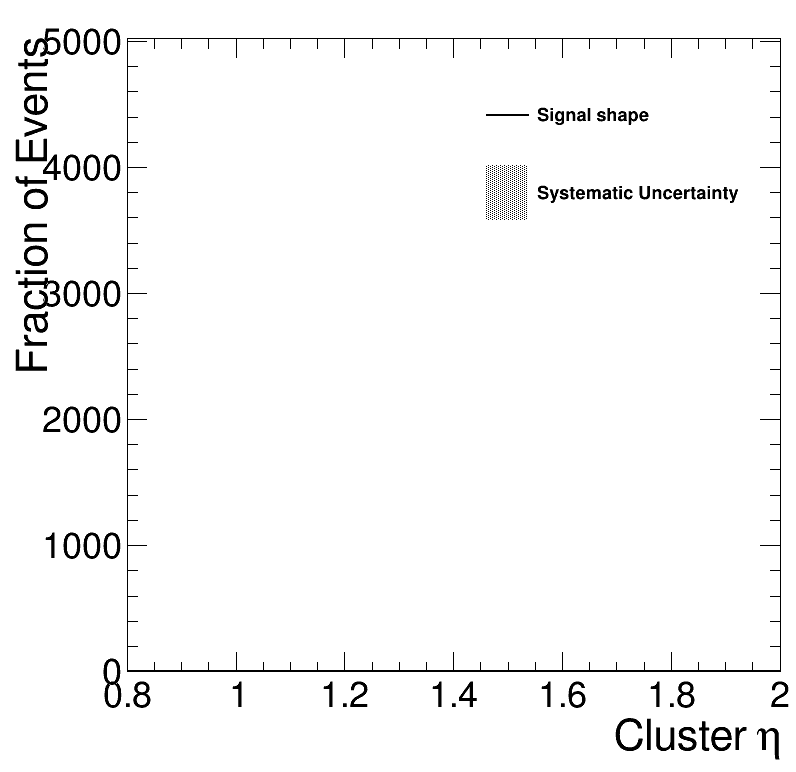

In [10]:
# uncertainty wrt cluster Eta distribution

import root_numpy
version = 'v28'

path = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/\
cluster_eff_year2017_norm50_V1p17'+version+'_tag_probe/'
print(path)
# suffix = "_Nrechits130"
suffix = ""
f = rt.TFile(path+'efficiency_Zmass120_800_muon50_norm50.root')
f.Get("data_ZMass")
data_eff_temp = f.Get("data_muonEta"+suffix)
mc_eff_temp = f.Get("dy_120_800_muonEta"+suffix)
data_eff = data_eff_temp.GetCopyPassedHisto()
mc_eff = mc_eff_temp.GetCopyPassedHisto()
for i in range(data_eff.GetXaxis().GetNbins()+1):
    data_eff.SetBinContent(i+1,data_eff_temp.GetEfficiency(i+1))
    mc_eff.SetBinContent(i+1,mc_eff_temp.GetEfficiency(i+1))
    data_eff.SetBinError(i+1,max(data_eff_temp.GetEfficiencyErrorLow(i+1), data_eff_temp.GetEfficiencyErrorUp(i+1)))
    mc_eff.SetBinError(i+1,max(mc_eff_temp.GetEfficiencyErrorLow(i+1), mc_eff_temp.GetEfficiencyErrorUp(i+1)))

sf_eff = data_eff
sf_eff.Divide(mc_eff)
unc_list = sf_eff

def signal_weight(sf_eff, eta_distribution):
    unct = []
    for ele in eta_distribution:
        unct.append(sf_eff.GetBinContent(sf_eff.GetXaxis().FindFixBin(ele)))
    return np.array(unct)
def signal_weight_unc(sf_eff, eta_distribution):
    unct = []
    for ele in eta_distribution:
        # relative uncertainty
#         unct.append(sf_eff.GetBinError(sf_eff.GetXaxis().FindFixBin(ele))/sf_eff.GetBinContent(sf_eff.GetXaxis().FindFixBin(ele)))
        unct.append(sf_eff.GetBinError(sf_eff.GetXaxis().FindFixBin(ele)))
    return np.array(unct)


sig = []
w = []

for k,T in tree.items():
    if 'data' in k:continue
    if np.count_nonzero(sel_ev[k]) == 0: continue
    sig += list(np.abs(cscRechitClusterEta[k]))
    w += list(T.array('pileupWeight')[sel_ev[k]] * T.array('weight')[sel_ev[k]] * T.array('higgsPtWeight')[sel_ev[k]])
    temp = T.array('pileupWeight')[sel_ev[k]] * T.array('weight')[sel_ev[k]] * T.array('higgsPtWeight')[sel_ev[k]]
    print(k, np.sum(temp*signal_weight(unc_list,np.abs(cscRechitClusterEta[k])))/np.sum(temp)-1)
sig_weight = signal_weight(unc_list, sig)
print(sig_weight[:10])
sig_weight_unc = 0
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.6, 0.7, 0.9, 0.9)
leg.SetBorderSize(0)
leg.SetTextSize(0.025)
leg.SetFillStyle(0)
sig_hist = create_TH1D(sig, 'hm1', axis_title = ['Cluster #eta','Fraction of Events'], binning=[unc_list.GetXaxis().GetNbins(), unc_list.GetXaxis().GetXmin(), unc_list.GetXaxis().GetXmax()], weights = w)
sig_up = create_TH1D(sig, 'hm1', axis_title = ['',''], binning=[unc_list.GetXaxis().GetNbins(), unc_list.GetXaxis().GetXmin(), unc_list.GetXaxis().GetXmax()], weights = w*sig_weight)
sig_down = create_TH1D(sig, 'hm1', axis_title = ['',''], binning=[unc_list.GetXaxis().GetNbins(), unc_list.GetXaxis().GetXmin(), unc_list.GetXaxis().GetXmax()], weights = w*(2-sig_weight))
sig_unc = create_TH1D(sig, 'hm1', axis_title = ['Cluster #eta','Relative Uncertainty (%)'], binning=[unc_list.GetXaxis().GetNbins(), unc_list.GetXaxis().GetXmin(), unc_list.GetXaxis().GetXmax()], weights = w*(2-sig_weight))

# set error bar to be the scale factor up and down uncertainty from cluster efficiency 
for j in range(sig_hist.GetXaxis().GetNbins()+1):
    sig_hist.SetBinError(j+1, abs(sig_up.GetBinContent(j+1)-sig_hist.GetBinContent(j+1)))
#     sig_unc.SetBinContent(j+1, sig_hist.GetBinError(j+1)/sig_hist.GetBinContent(j+1))
    
    if sig_hist.GetBinContent(j+1):
        sig_unc.SetBinError(j+1, 100*unc_list.GetBinError(j+1))
        sig_unc.SetBinContent(j+1, 100*abs(unc_list.GetBinContent(j+1)-1))
#         print(sig_hist.GetBinCenter(j+1), sig_hist.GetBinError(j+1)/sig_hist.GetBinContent(j+1))
    else:
        sig_unc.SetBinError(j+1, 0.0)

sig_unc_graph = rt.TGraphAsymmErrors(sig_unc) 
sig_unc_graph.SetTitle(";cluster #eta;Relative Uncertainty (%)");
# set the lower end of y-uncertainty to 0, if it becomes negative
for i in range(sig_unc.GetXaxis().GetNbins()+1):
    if sig_unc.GetBinContent(i+1) <sig_unc.GetBinError(i+1):sig_unc_graph.SetPointEYlow(i,sig_unc.GetBinContent(i+1))




sig_hist.Scale(1./sig_hist.Integral())
sig_hist.GetYaxis().SetRangeUser(0, 1.5*max(map(lambda x: x.GetMaximum(), [sig_hist, sig_up, sig_down])))
sig_hist.DrawCopy('hist')

sig_hist_unc = sig_hist.Clone()
sig_hist_unc.SetFillStyle(3002)
sig_hist_unc.SetFillColor(1)
sig_hist_unc.SetLineWidth(0)
leg.AddEntry(sig_hist,'Signal shape','L')
leg.AddEntry(sig_hist_unc,'Systematic Uncertainty','F')
sig_hist_unc.DrawCopy('same E2')

leg.Draw()




sig_unc_graph.GetXaxis().SetRangeUser(0.8,2)
# sig_unc_graph.Draw('AP')



c.Draw()


for j in range(sig_hist.GetXaxis().GetNbins()+1):
    sig_weight_unc += (sig_hist.GetBinContent(j+1)*sf_eff.GetBinError(j+1))**2
sig_weight_unc = sig_weight_unc**0.5


total_unc = np.sum(w*(sig_weight))/np.sum(w)-1
print("signal uncertainty", np.sum(w*(sig_weight))/np.sum(w)-1,1-np.sum(w*(2-sig_weight))/np.sum(w), sig_weight_unc/np.sum(w))
print(sig_up.Integral()/sig_hist.Integral(), sig_down.Integral()/sig_hist.Integral())

# signal yield summary table

In [22]:
ctaus = ['5','10','30','40', '50','60','80', '100','200','300','500','1000', '2000','3000','5000', '10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000'] #mm
ctaus = ['100', '500','1000', '5000', '10000',\
         '100000', '1000000'] #mm
ctaus = ['500', '1000', '10000', '100000', '1000000']
ctaus = [  '100']
# ctaus = ['100', '1000',]
ctaus = [ '100', '1000','10000','100000' ]
# ctaus = ['500', '1000', '10000', '100000', '1000000']

# ctaus = [ '10000','100000' ]

# ctaus = [  '1000' ]


# ctaus = [  '10000','100000' ]


BR = 0.01
N_RECHIT_CUT = 130
DPHI_CUT = 0.75



var = dphiMet_cluster
# DPHI_CUT = 0.6      
# var = jetMet_dPhiMin30
for N_RECHIT_CUT in np.arange(60,220,10):
    if not N_RECHIT_CUT==130:continue
    total_sig = 0
    for m in mass:
#         if not m == 55:continue
        signal_rate = []
        unc_rate = []
        signal_unc = []
        for ct in ctaus:   
#             if not ct == '1000':continue
            signal = 0
            sig_unc = 0
            shape_unc_temp = 0
            ctf = int(ct)
            if ctf < OLD_CTAU[0]:
                old_ctau_temp = np.array([OLD_CTAU[0]])
            else:
                for j, ct0 in enumerate(OLD_CTAU):
                    if ct0 == ctf: 
                        old_ctau_temp = np.array([int(ctf)])
                        break

                    elif ct0 > ctf:
                        old_ctau_temp = np.array([OLD_CTAU[j-1], OLD_CTAU[j]])
                        old_ctau_temp = np.array([OLD_CTAU[j]])
                        break
                    if j == len(OLD_CTAU)-1: 
                        old_ctau_temp = np.array([OLD_CTAU[j]])
#             print(ct,old_ctau_temp)

            weight_sum = 0
            weight_len = 0
            for j,ct0 in enumerate(old_ctau_temp):
#                 if VBFH: prods = ['ggH', 'VBFH']
#                 else: prods = ['ggH']
                prods = ['ggH']
                for prod in prods:
                    production = 'ggH'
                    k = 'MC_'+production+'_'+str(m)+'_'+str(ct0)
                    T = tree[k]
                    if np.count_nonzero(sel_ev[k]) == 0: continue
                    gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev[k]][bdt_sel[k]]
                    if len(gLLP_ctau) == 0: continue
                    weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau_temp/10) # convert everything to cm
                    w = weight[k]
#                         w = weight_ctau* weight[k]
#                     shape_unc = signal_weight(unc_list, np.abs(cscRechitClusterEta[k][bdt_sel[k]]))
                    # higgs pt, signal uncertainty weight
                    cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, np.abs(var[k])<DPHI_CUT)

                    signal += np.sum(w[cond])
                    sig_unc +=np.sum(w[cond]*w[cond])
#                     shape_unc_temp = (shape_unc_temp**2+np.sum(w[cond]*shape_unc[cond])**2)**0.5


            signal_rate.append(signal)
            signal_unc.append(sig_unc**0.5)
            unc_rate.append(shape_unc_temp)
        signal_rate = np.array(signal_rate)
        unc_rate = np.array(unc_rate)
        signal_unc = np.array(signal_unc)
#         print(N_RECHIT_CUT, '\t', signal_rate[0]*BR)
        print(m, '\t', '\t'.join(map(str, [round(num,2) for num in signal_rate*BR])))
#         print(m, '\t', '\t'.join(map(str, [round(num,2) for num in signal_unc*BR])))
#         print(m, '\t', '\t'.join(map(str, [round(num,2) for num in signal_unc/signal_rate])))

    
#         print(m, '\t'.join(map(str,[round(num,2) for num in unc_rate*BR]))) #signal mc relative uncertainty
        total_sig += np.sum(signal_rate)
# print(total_sig*BR)

#     print(m, '\t'.join(map(str,unc_rate/signal_rate))) #signal mc relative uncertainty



15 	 6.98	23.58	5.59	0.68
40 	 0.19	18.81	16.27	1.86
55 	 0.0	8.07	20.34	3.15


# signal uncertainties

In [23]:
jetVeto = {}
rechitVeto = {}
cut_based_eff_unc = {}
clusterEff_unc = {}
higgsPtWeight = {}
JES = {}
pileup = {}
# ctau_reweight = {}
mc_stats = {}

lumi = {}
Nrechit_weight_file = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/Uncertainties/Nrechit_weight.txt'

cut_based_unc = [0.0867, 0.0754]
clustering_unc = [0.1506, 0.1047]
for k in list(tree.keys()):
    if not 'MC' in k:continue
    cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=130, nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<250)
    Nrechits130= np.sum((weight[k])[cond])
    cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=250
    Nrechits250= np.sum(weight[k][cond])
    if Nrechits130+Nrechits250 >0:
        Nrechits130_ratio = Nrechits130/(Nrechits130+Nrechits250)
        Nrechits250_ratio = Nrechits250/(Nrechits130+Nrechits250)
    else:
        Nrechits130_ratio = 0
        Nrechits250_ratio = 0
        
    lumi[k] = [0.018]*4
    jetVeto[k] = [0.0154]*4
    rechitVeto[k] = [0.031]*4
    cutBased_highNhits = Nrechits130_ratio*cut_based_unc[0]+Nrechits250_ratio*cut_based_unc[1]
    cut_based_eff_unc[k]=[cutBased_highNhits, 0.0075, 0.0075, cutBased_highNhits]
    clusterEff_highNhits = Nrechits130_ratio*clustering_unc[0]+Nrechits250_ratio*clustering_unc[1]
    clusterEff_unc[k]  = [clusterEff_highNhits, 0.0089, 0.0089, clusterEff_highNhits]
    JES[k] = [0.084,0.083,0.042,0.041]
    pileup[k] = [0.008, 0.0110, 0.0110, 0.0110]
    if 'ggH' in k: higgsPtWeight[k] = [0.205, 0.205,0.207,0.208, 0.133,0.133,0.134,0.134] #down/up
    else:higgsPtWeight[k] = [0]*8 #down/up
    mc_stats[k] = []

    

sig_eff = [lumi, jetVeto,rechitVeto,cut_based_eff_unc, clusterEff_unc,JES,pileup, higgsPtWeight, mc_stats]
sig_eff_name = ['lumi','jetVeto','rechitVeto','cut_based_eff_unc', 'clusterEff_unc','JES','pileup', 'higgsPtWeight','mc_stats']

# Signal Contamination

In [15]:
ctaus = ['5','10','30','40', '50','60','80', '100','200','300','500','1000', '2000','3000','5000', '10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000'] #mm
ctaus = ['100', '500','1000', '5000', '10000',\
         '100000', '1000000'] #mm
ctaus = ['500', '1000', '10000', '100000', '1000000']
BR = 0.002
N_RECHIT_CUT = 130
DPHI_CUT = 0.75      
# DPHI_CUT = 0.6   
jetmet = 0
if jetmet: var = jetMet_dPhiMin30
else:var = dphiMet_cluster
for N_RECHIT_CUT in [170]:
    factor = len(var['data_intime_vr'])/len(var['data_oot_vr'])
    k = 'data_oot_sr'
    bkg = 0
    if jetmet: bkg = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT)) 
    else: bkg = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
    print(bkg)
    bkg *= factor
    for m in mass:
        signal_rate = []
        unc_rate = []
        for ct in ctaus:   
            signal = 0
            shape_unc_temp = 0
            ctf = int(ct)
            for i, y in enumerate(years):
                if ctf < OLD_CTAU[0]:
                    old_ctau_temp = np.array([OLD_CTAU[0]])
                else:
                    for j, ct0 in enumerate(OLD_CTAU):
                        if ct0 == ctf: 
                            old_ctau_temp = np.array([ctf])
                            break
                        elif ct0 > ctf:
                            old_ctau_temp = np.array([OLD_CTAU[j-1], OLD_CTAU[j]])
                            old_ctau_temp = np.array([OLD_CTAU[j]])
                            break
                        if j == len(OLD_CTAU)-1: 
                            old_ctau_temp = np.array([OLD_CTAU[j]])
                weight_sum = 0
                weight_len = 0
                for j,ct0 in enumerate(old_ctau_temp):
                    if VBFH: prods = ['ggH', 'VBFH']
                    else: prods = ['ggH']
                    for prod in prods:
                        k = 'MC_'+y+'_'+prod+'_'+str(m)+'_'+str(ct0)
                        T = tree[k]
                        if np.count_nonzero(sel_ev[k]) == 0: continue
                        gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev[k]][bdt_sel[k]]
                        if len(gLLP_ctau) == 0: continue
                        weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau_temp/10) # convert everything to cm
                        w = pileupWeight[k] * weight[k] * weight_ctau * higgsPtWeight[k]
                        shape_unc = signal_weight(unc_list, np.abs(cscRechitClusterEta[k][bdt_sel[k]]))
                        # higgs pt, signal uncertainty weight
#                         cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]<DPHI_CUT)
                        if jetmet: cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]<DPHI_CUT) #bin D
                        else: cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]>=DPHI_CUT) #bin A
                        signal += np.sum(w[cond])
                        shape_unc_temp = (shape_unc_temp**2+np.sum(w[cond]*shape_unc[cond])**2)**0.5
    #                     print(np.sum(w[cond]*sf_facScaleUp[k][cond])/np.sum(w[cond]), np.sum(w[cond]*sf_facScaleDown[k][cond])/np.sum(w[cond]))
    #                     print(np.sum(w[cond]*sf_renScaleUp[k][cond])/np.sum(w[cond]), np.sum(w[cond]*sf_renScaleDown[k][cond])/np.sum(w[cond]))
    #                     print(np.sum(w[cond]*sf_facRenScaleUp[k][cond])/np.sum(w[cond]), np.sum(w[cond]*sf_facRenScaleDown[k][cond])/np.sum(w[cond]))


            signal_rate.append(signal)
            unc_rate.append(shape_unc_temp)
        signal_rate = np.array(signal_rate)
        unc_rate = np.array(unc_rate)
#         print(N_RECHIT_CUT, '\t', signal_rate[0]*BR)
#         print(m, '\t', '\t'.join(map(str, [round(num,2) for num in signal_rate*BR])))
        print(m, '\t', '\t'.join(map(str, [round(num/bkg,2) for num in signal_rate*BR])))


#         print(m, '\t'.join(map(str,[round(num,2) for num in unc_rate*BR]))) #signal mc relative uncertainty


#     print(m, '\t'.join(map(str,unc_rate/signal_rate))) #signal mc relative uncertainty

print(bkg)


1
15 	 0.51	1.22	0.93	0.11	0.0
40 	 0.01	0.09	0.38	0.05	0.0
55 	 0.0	0.0	0.01	0.0	0.0
0.3658051689860835


# make datacard cleaned version

In [28]:
import os
import math
import importlib
importlib.reload(sys.modules['helper'])
from helper import make_datacard, make_datacard_2sig, weight_calc
#methodB use oot vr and ABCD method
#methodC use the fit functions
N_RECHIT_CUTS = np.arange(60,220, 5)
# N_RECHIT_CUTS = [130]
ctaus = ['5','10','30','40', '50','60','80', '100','200','300','500','1000', '2000','3000','5000', '10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000'] #mm
# ctaus = ['100','200','300','500','1000', '2000','3000','5000', '10000', '20000','30000','50000',\
#          '100000', '200000', '300000', '500000', '1000000'] #mm


# ctaus = ['10000', '20000']
UNBLIND = 0
method = 1
fit_function = 'se' #se, me, sp
jetmet=0
datacard_version  = 'v7'
if datacard_version == 'v1':
    bkg_unc = 1.0
    sig_unc0 = 0.2
elif datacard_version == 'v2':
    bkg_unc = 0.5
    sig_unc0 = 0.2
elif datacard_version == 'v3':
    bkg_unc = 1.0
    sig_unc0 = 0.3
elif datacard_version == 'v4':#used non-closure+stat error for background
    bkg_unc = 0.0
    sig_unc0 = 0.2
elif datacard_version == 'v5':#used stat error for background
    bkg_unc = 0.0
    sig_unc0 = 0.2
else:
    bkg_unc = [] #list of two uncertainty, each element is N for the gamma uncertainty distriubtion, alpha is calculated in the makr_datacard method
    bkg_unc_name = ['ABCD_intimeVR', 'ABCD_OOTSR']
    print("ERROR in uncertainty assignment")
if jetmet: 
    var = jetMet_dPhiMin30
    DPHI_CUT = 0.6
    DPHI_CUTS = [0.6]
else: 
    var = dphiMet_cluster
    DPHI_CUT = 0.75
    DPHI_CUTS = [0.75]

# print(bdtBkgEff_nrechit.shape)
bkg = []
print(N_RECHIT_CUTS)
for N_RECHIT_CUT in N_RECHIT_CUTS:
    for DPHI_CUT in DPHI_CUTS:
        bkg_unc = []
        ##### method B (use OOT high BDT region and tha ratio between intime and OOT)#####
        k = 'data_intime_vr'
        a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
        b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT)) 
        c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT)) 
        d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT)) 
        pred = a*c/b
        if datacard_version == 'v4': 
            unc = (abs(d-pred)/pred)**2+pred/pred**2
        else:
            bkg_unc.append(1./pred**0.5) # only the statistical uncertainty(relative)
        factor = len(var['data_intime_vr'])/len(var['data_oot_vr'])
        k = 'data_oot_sr'
        a = factor * np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
        b = factor * np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT)) 
        c = factor * np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT)) 
        d = factor * np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT)) 

        pred = a*c/b
        if datacard_version == 'v4': 
            bkg_unc = (unc + (abs(d-pred)/pred)**2+pred/pred**2)**0.5
        else:
            bkg_unc.append(1./(pred/factor)**0.5) # only the statistical uncertainty(relative)
        bkg_rate = np.array([a,b,c,pred])
        observation = bkg_rate
        if UNBLIND:
            k = 'data_intime_sr'
            a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
            b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT)) 
            c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT)) 
            d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT)) 
            bkg_rate = np.array([a,b,c,a*c/b])
            observation= np.array([a,b,c,d])
        print(N_RECHIT_CUT, observation, bkg_unc)
        
        #####
        # a = c*c1*c2
        # b = c1* c
        # c = c
        # d = c2*c
        # start adding signal
        #####
        outDataCardsDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+\
        ntupler_version+analyzer_version+'/'
        if cut_based:outDataCardsDir += 'cut_based_'+cut_based_version+'/'
        else: outDataCardsDir += bdt_name+'/'
        outDataCardsDir += datacard_version+'/methodB/'
        if UNBLIND: outDataCardsDir += 'unblind/'
        else:outDataCardsDir += 'blind/'
        if not os.path.isdir(outDataCardsDir):os.makedirs(outDataCardsDir)
        print(outDataCardsDir)
        sig_norm = []
        for m in mass:
            for ct in ctaus:
                dphi = str(DPHI_CUT).replace(".", "p")
                if VBFH: modelName = 'VBFH_HToSSTo'+decay
                else: modelName = 'ggh_HToSSTo'+decay
                modelName = modelName + '_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+str(N_RECHIT_CUT)+'dPhiCluster'+dphi
                signal_rate = {'ggH':np.zeros((4,)),'VBFH':np.zeros((4,)) }
                mc_stat_unc = {'ggH':np.zeros((4,)),'VBFH':np.zeros((4,)) }
                sig_unc = {'ggH':[],'VBFH':[] }
                ctf = int(ct)
                ct_list = 10**int(math.log10(ctf))
                if ctf < OLD_CTAU[0]: ct_list = [OLD_CTAU[0]]
                elif ctf>OLD_CTAU[-1]: ct_list = [OLD_CTAU[-1]]
                elif ct_list == int(ct): ct_list = [int(ct)]
                else:ct_list = [ct_list,ct_list*10]
                    
                if VBFH: prods = ['ggH', 'VBFH']
                else: prods = ['ggH']
                for prod in prods:
                    for i, ct0 in enumerate(ct_list):
                        k = 'MC_'+prod+'_'+str(m)+'_'+str(ct0)
                        T = tree[k]
                        if np.count_nonzero(sel_ev[k])==0:continue
                        gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev[k]][bdt_sel[k]]
                        weight_ctau = weight_calc(gLLP_ctau, int(ct)/10, int(ct0)/10) # convert everything to cm
                        if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
                        else:
                            if i == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                            else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
                        w = weight[k]*weight_ctau
                        cond = np.logical_and(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]>=DPHI_CUT), weight_cond)
                        signal_rate[prod][0]+=np.sum(w[cond])
                        mc_stat_unc[prod][0]+=np.sum(w[cond]**2)
                        cond = np.logical_and(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]>=DPHI_CUT), weight_cond)
                        signal_rate[prod][1]+=np.sum(w[cond])
                        mc_stat_unc[prod][1]+=np.sum(w[cond]**2)
                        cond = np.logical_and(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]<DPHI_CUT), weight_cond)
                        signal_rate[prod][2]+=np.sum(w[cond])
                        mc_stat_unc[prod][2]+=np.sum(w[cond]**2)
                        cond = np.logical_and(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]<DPHI_CUT), weight_cond)
                        signal_rate[prod][3]+=np.sum(w[cond])
                        mc_stat_unc[prod][3]+=np.sum(w[cond]**2)
                    mc_stat_unc[prod] = list(np.nan_to_num(np.sqrt(mc_stat_unc[prod])/signal_rate[prod])) #convert absolute to relative uncertainty
                    for j, ele in enumerate(sig_eff):
                        if j == len(sig_eff)-1:
                            sig_unc[prod].append(mc_stat_unc[prod])
                        else:
                            sig_unc[prod].append(ele[k])
                norm = np.sum(signal_rate['VBFH']+signal_rate['ggH'])/4
                if norm == 0:continue
                sig_norm.append(norm)
                if VBFH:
                    make_datacard_2sig(outDataCardsDir, modelName, signal_rate['ggH']/norm,signal_rate['VBFH']/norm, norm, bkg_rate, observation, \
                                  bkg_unc, bkg_unc_name, sig_unc['ggH'], sig_unc['VBFH'], sig_eff_name)
                
                else:
                    if datacard_version == 'v5':make_datacard(outDataCardsDir, modelName, jetmet, signal_rate['ggH']/norm, norm, observation, \
                                  bkg_unc, np.array([sig_unc0, sig_unc0, sig_unc0, sig_unc0]))
    
                    else:
                        print(modelName)
#                         print(outDataCardsDir)
#                         print(bkg_rate,observation)
#                         print(bkg_rate)
#                         print(m,ct, sig_unc['ggH'][-1])
                        make_datacard(outDataCardsDir, modelName, signal_rate['ggH']/norm, norm, bkg_rate, observation, \
                                  bkg_unc, bkg_unc_name, sig_unc['ggH'], sig_eff_name)


ERROR in uncertainty assignment
[ 60  65  70  75  80  85  90  95 100 105 110 115 120 125 130 135 140 145
 150 155 160 165 170 175 180 185 190 195 200 205 210 215]
60 [61.93962999 78.60175268 23.18208374 18.26790931] [0.14701327567878505, 0.14081269961998816]
/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/V1p17/v1/v66//cut_based_v4/v7/methodB/blind/
ggh_HToSSTobbbb_mh125_mx15_ctau5mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau10mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau30mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau40mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau50mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau60mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau80mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau100mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau200mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx15_ctau300mm

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


ggh_HToSSTobbbb_mh125_mx40_ctau10mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau30mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau40mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau50mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau60mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau80mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau100mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau200mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau300mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau500mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau1000mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau2000mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau3000mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau5000mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau10000mm_nRechit60dPhiCluster0p75
ggh_HToSSTobbbb_mh125_mx40_ctau20000mm_nRechit60dPhiCluster0p75
ggh_HT

ZeroDivisionError: float division by zero

# make datacard

In [23]:
import os
#methodB use oot vr and ABCD method
#methodC use the fit functions
N_RECHIT_CUTS = np.arange(60,220, 10)
ctaus = ['5','10','30','40', '50','60','80', '100','200','300','500','1000', '2000','3000','5000', '10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000'] #mm
UNBLIND = False
method = 1
fit_function = 'se' #se, me, sp
jetmet=0
datacard_version  = 'v5'
if datacard_version == 'v1':
    bkg_unc = 1.0
    sig_unc0 = 0.2
elif datacard_version == 'v2':
    bkg_unc = 0.5
    sig_unc0 = 0.2
elif datacard_version == 'v3':
    bkg_unc = 1.0
    sig_unc0 = 0.3
elif datacard_version == 'v4':#used non-closure+stat error for background
    bkg_unc = 0.0
    sig_unc0 = 0.2
elif datacard_version == 'v5':#used stat error for background
    bkg_unc = 0.0
    sig_unc0 = 0.2
else:
    print("ERROR in uncertainty assignment")
if jetmet: 
    var = jetMet_dPhiMin30
    DPHI_CUT = 0.6
    DPHI_CUTS = [0.6]
else: 
    var = dphiMet_cluster
    DPHI_CUT = 0.75
    DPHI_CUTS = [0.75]

# print(bdtBkgEff_nrechit.shape)
bkg = []

for N_RECHIT_CUT in N_RECHIT_CUTS:
    for DPHI_CUT in DPHI_CUTS:
        if method==0:
            ##### method A (use intime validation region and bdt efficiency)#####
            eff_path = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/bdt_eff/'
            if cut_based:eff_file = eff_path +'cut_based.txt'
            else: eff_file = eff_path + bdt_name +'.txt'
            print(eff_file)
            bdtBkgEff_nrechit = np.genfromtxt(eff_file, delimiter=',')
            row, _ = np.argwhere(bdtBkgEff_nrechit == N_RECHIT_CUT)[0]
            lowN_eff = bdtBkgEff_nrechit[row,1]
            sig_lowN_eff = bdtBkgEff_nrechit[row,2]
            highN_eff = bdtBkgEff_nrechit[row,3]
            sig_highN_eff = bdtBkgEff_nrechit[row,4]
            k = 'data_oot_sr'
            a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
            b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT))
            c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT))
            d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT))
            oot_unc = abs(d-a*c/b)/(a*c/b)
            
            k = 'data'
            a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
            b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT))
            c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT))
            d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT))
            observation = []
            if jetmet:
                pred = b*d/c
                stat_unc = (1./b + 1./c + 1./d)**0.5*(pred)
                sys_unc = abs(a-pred)
                unc = np.array([(stat_unc**2 + sys_unc**2)**0.5/pred, 0.0, 0.0, 0.0]) # relative uncertainty
                observation = np.array([pred, b,c,d])
            else:
                pred = a*c/b
                if a>0 and b>0 and c>0:stat_unc = (1./a + 1./c + 1./b)**0.5*(pred)
                else:stat_unc = 0.0
                sys_unc = abs(d-pred)
                if pred > 0: unc = np.array([0.0, 0.0, 0.0, (stat_unc**2 + sys_unc**2)**0.5/pred]) #relative uncertainty
                else: unc = np.array([0.0,0.0,0.0,0.0])
                observation = np.array([a,b,c,pred])
    #         print(N_RECHIT_CUT, stat_unc, sys_unc, unc)
            highEffUp = highN_eff + sig_highN_eff
            lowEffUp = lowN_eff + sig_lowN_eff
            a_up = a/(1-highEffUp)*highEffUp
            b_up = b/(1-lowEffUp)*lowEffUp
            c_up = c/(1-lowEffUp)*lowEffUp
            d_up = d/(1-highEffUp)*highEffUp

            highEffDown = highN_eff - sig_highN_eff
            lowEffDown = lowN_eff - sig_lowN_eff
            a_down = a/(1-highEffDown)*highEffDown
            b_down = b/(1-lowEffDown)*lowEffDown
            c_down = c/(1-lowEffDown)*lowEffDown
            d_down = d/(1-highEffDown)*highEffDown
    #         print(a,b,c,d,pred)
            a = a/(1-highN_eff)*highN_eff
            b = b/(1-lowN_eff)*lowN_eff
            c = c/(1-lowN_eff)*lowN_eff
            d = d/(1-highN_eff)*highN_eff    
            pred = pred/(1-highN_eff)*highN_eff
            if jetmet: observation = np.array([pred, b,c,d])
            else: observation = np.array([a,b,c,pred])
            bdt_unc = [max(abs(a-a_down), abs(a-a_up)), max(abs(b-b_down), abs(b-b_up)), max(abs(c-c_down), abs(c-c_up)), max(abs(d-d_down), abs(d-d_up))]

            for i in range(4):
    #             print(unc[i]*observation[i], bdt_unc[i])
                unc[i] = ((unc[i]*observation[i])**2 + bdt_unc[i]**2)**0.5/observation[i]
            unc[3] = (oot_unc**2+unc[3]**2)**0.5
#             print(N_RECHIT_CUT, '\t', d)
            print(N_RECHIT_CUT, pred)
        elif method == 1:
            ##### method B (use OOT high BDT region and tha ratio between intime and OOT)#####
            k = 'data_intime_vr'
            a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
            b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT)) 
            c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT)) 
            d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT)) 
            if jetmet: 
                pred = b*d/c
                unc = (abs(a-pred)/pred)**2+pred/pred**2
            else: 
                pred = a*c/b
                if datacard_version == 'v4': 
                    unc = (abs(d-pred)/pred)**2+pred/pred**2
                elif datacard_version == 'v5':
                    unc = 1.0/pred # only the statistical uncertainty(relative)
            factor = len(var['data_intime_vr'])/len(var['data_oot_vr'])
            k = 'data_oot_sr'
            a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
            b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT)) 
            c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT)) 
            d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT)) 
            if jetmet:
                pred = b*d/c
                stat_unc = (1./b + 1./c + 1./d)**0.5*(pred)
                if datacard_version == 'v4': 
                    bkg_unc = (unc + (abs(a-pred)/pred)**2+pred/pred**2)**0.5
                elif datacard_version == 'v5':
                    bkg_unc = (unc + 1.0/pred)**0.5 # only the statistical uncertainty (relative)

            else:
                pred = a*c/b
                stat_unc = (1./a + 1./c + 1./b)**0.5*(pred)
                sys_unc = abs(d-pred)
                if datacard_version == 'v4': 
                    bkg_unc = (unc + (abs(d-pred)/pred)**2+pred/pred**2)**0.5
                elif datacard_version == 'v5':
                    bkg_unc = (unc + 1.0/pred)**0.5 # only the statistical uncertainty(relative)
#             print(N_RECHIT_CUT, pred)
            a = a * factor
            b = b * factor
            c = c * factor
            d = d * factor
            pred = pred * factor
            if jetmet: observation = np.array([pred,b,c,d])
            else:observation = np.array([a,b,c,pred])
            print(N_RECHIT_CUT, observation, bkg_unc)
        else:
            #open text file for the corresponding fit function
            fit_dir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/fits_roofit/integral/'+ntupler_version+analyzer_version+'/'
            if cut_based:fit_dir += 'cut_based_'+cut_based_version+'/'
            else: fit_dir += bdt_name+'/'
            if jetmet: fit_dir += 'jetMet_dPhiMin30/'
            else: fit_dir += 'dphiMet_cluster/'
            factor = len(var['data_intime_vr'])/len(var['data_oot_vr'])
            if jetmet: integral = np.genfromtxt(fit_dir+'Ncsc_Fits_oot_BDTbin1_A_'+fit_function+'.txt', delimiter=',')            
            else:  integral = np.genfromtxt(fit_dir+'Ncsc_Fits_oot_BDTbin1_D_'+fit_function+'.txt', delimiter=',')   
            k = 'data_oot_sr'
            b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] >= DPHI_CUT)) 
            c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < N_RECHIT_CUT, var[k] < DPHI_CUT)) 
            pred = 0.0
            if jetmet:
                a = integral[integral[:,0]==N_RECHIT_CUT][0,1]
                d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] < DPHI_CUT))
                pred = a
            else:
                a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= N_RECHIT_CUT, var[k] >= DPHI_CUT))
                d = integral[integral[:,0]==N_RECHIT_CUT][0,1]
                pred = d
            observation = np.array([a,b,c,d])*factor
            print(N_RECHIT_CUT, pred*factor,observation)
        #####
        # a = c*c1*c2
        # b = c1* c
        # c = c
        # d = c2*c
        # start adding signal
        #####
        outDataCardsDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+\
        ntupler_version+analyzer_version+'/'
        if cut_based:outDataCardsDir += 'cut_based_'+cut_based_version+'/'
        else: outDataCardsDir += bdt_name+'/'
        outDataCardsDir += datacard_version+'/'
        if method==0: outDataCardsDir = outDataCardsDir + '/methodA/'
        elif method == 1: outDataCardsDir = outDataCardsDir + '/methodB/'
        else: outDataCardsDir = outDataCardsDir + '/methodC_'+fit_function+'/'
        if not os.path.isdir(outDataCardsDir):os.makedirs(outDataCardsDir)
        print(outDataCardsDir)
        sig_norm = []
        for m in mass:
            for ct in ctaus:
                dphi = str(DPHI_CUT).replace(".", "p")
                if VBFH: modelName = 'VBFH_HToSSTo'+decay
                else: modelName = 'ggh_HToSSTo'+decay
                if jetmet:
                    modelName = modelName + '_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+str(N_RECHIT_CUT)+'dPhiJet'+dphi
                else:
                    modelName = modelName + '_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+str(N_RECHIT_CUT)+'dPhiCluster'+dphi
                signal_rate = {'ggH':np.zeros((4,)),'VBFH':np.zeros((4,)) }
                sig_unc = {'ggH':np.zeros((4,)),'VBFH':np.zeros((4,)) }
                ctf = int(ct)
                for i, y in enumerate(years):
                    for j in range(len(OLD_CTAU)):
                        if ctf == OLD_CTAU[j]:
                            ct0 = OLD_CTAU[j]
                            break
                        elif ctf > OLD_CTAU[j] and j == len(OLD_CTAU)-1 :
                            ct0 = OLD_CTAU[j]
                            break
                        elif ctf< OLD_CTAU[j] and j == 0:
                            ct0 = OLD_CTAU[j]
                            break
                        else: continue
                    if VBFH: prods = ['ggH', 'VBFH']
                    else: prods = ['ggH']
                    for prod in prods:
                        k = 'MC_'+y+'_'+prod+'_'+str(m)+'_'+str(ct0)
                        T = tree[k]
                        if np.count_nonzero(sel_ev[k]) == 0: continue
                        gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev[k]][bdt_sel[k]]
                        if len(gLLP_ctau) == 0: continue
                        weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, np.array([ct0])/10) # convert everything to cm
                        w = pileupWeight[k] * weight[k] * weight_ctau * higgsPtWeight[k]
                        shape_unc = signal_weight(unc_list, np.abs(cscRechitClusterEta[k][bdt_sel[k]]))
                        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]>=DPHI_CUT)
                        signal_rate[prod][0]+=np.sum(w[cond])
                        if not np.sum(w[cond]) == 0:sig_unc[prod][0] += np.sum(w[cond]*shape_unc[cond])
                        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]>=DPHI_CUT)
                        signal_rate[prod][1]+=np.sum(w[cond])
                        if not np.sum(w[cond]) == 0:sig_unc[prod][1] += np.sum(w[cond]*shape_unc[cond])
                        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]<DPHI_CUT)
                        signal_rate[prod][2]+=np.sum(w[cond])
                        if not np.sum(w[cond]) == 0:sig_unc[prod][2] += np.sum(w[cond]*shape_unc[cond])
                        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]<DPHI_CUT)
                        signal_rate[prod][3]+=np.sum(w[cond])
                        if not np.sum(w[cond]) == 0:sig_unc[prod][3] += np.sum(w[cond]*shape_unc[cond])

#                 sig_unc['ggH'] = sig_unc['ggH']/signal_rate['ggH']
#                 sig_unc['ggH'][np.isnan(sig_unc['ggH'])] = 0.0
#                 if VBFH: 
#                     sig_unc['VBFH'] = sig_unc['VBFH']/signal_rate['VBFH']
#                     sig_unc['VBFH'][np.isnan(sig_unc['VBFH'])] = 0.0
#                 if np.count_nonzero(signal_rate['VBFH']<0)>0: print("VBFH", m, ct, sig_unc['VBFH'], signal_rate['VBFH'])
#                 if np.count_nonzero(signal_rate['ggH']<0)>0: print("ggH", m, ct, sig_unc['ggH'])


#                 print("signal", ct, m, signal_rate['ggH']*0.01, signal_rate['ggH'][3]/(signal_rate['ggH'][3]+signal_rate['ggH'][0]))
                norm = np.sum(signal_rate['VBFH']+signal_rate['ggH'])/4
#                 if norm == 0: continue
                sig_norm.append(norm)
#                 print(m, ct, norm)
                if VBFH:
#                     make_datacard_2sig(outDataCardsDir,modelName, jetmet, signal_rate['ggH']/norm, signal_rate['VBFH']/norm, norm, observation, \
#                                        unc, sig_unc['ggH'], sig_unc['VBFH'])
                    make_datacard_2sig(outDataCardsDir,modelName, jetmet, signal_rate['ggH']/norm, signal_rate['VBFH']/norm, norm, observation, \
                                       bkg_unc, np.array([sig_unc0, sig_unc0, sig_unc0, sig_unc0]), np.array([sig_unc0, sig_unc0, sig_unc0, sig_unc0]))
                
                else:
#                     make_datacard(outDataCardsDir, modelName, jetmet, signal_rate['ggH']/norm, norm, observation, unc, sig_unc['ggH'])
#                     make_datacard(outDataCardsDir, modelName, jetmet, signal_rate['ggH']/norm, norm, observation, \
#                                   np.array([1.0, 1.0, 1.0, 1.0]), np.array([0.3, 0.3, 0.3, 0.3]))
                    make_datacard(outDataCardsDir, modelName, jetmet, signal_rate['ggH']/norm, norm, observation, \
                                  bkg_unc, np.array([sig_unc0, sig_unc0, sig_unc0, sig_unc0]))
                    

60 [63.00097371 79.02434275 23.3067186  18.58093234] 0.20380007926954813
/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/V1p17/v1/v53//cut_based_v4/v5//methodB/


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in true_divide


70 [ 36.05258033 105.97273612  30.22590068  10.28303838] 0.2873193901393053
/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/V1p17/v1/v53//cut_based_v4/v5//methodB/
80 [ 20.0292113  121.99610516  33.50340798   5.50055952] 0.37314318515436
/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/V1p17/v1/v53//cut_based_v4/v5//methodB/
90 [ 13.11002921 128.91528724  36.05258033   3.6663641 ] 0.45597418557683494
/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/V1p17/v1/v53//cut_based_v4/v5//methodB/
100 [ 10.19668939 131.82862707  36.78091529   2.84493267] 0.5472058379962694
/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/V1p17/v1/v53//cut_based_v4/v5//methodB/
110 [  5.82667965 136.19863681  36.78091529   1.57351509] 0.7633384855778964
/storage/user/chris

ZeroDivisionError: float division by zero

In [13]:
import math
from scipy.stats import norm

# unblind

In [16]:
k = 'data_intime_sr'

n_ev = 5000
var = np.abs(dphiMet_cluster[k])
DPHI_CUT = 0.75
print("Nrechits, A, B, C, pred, D")
for N_RECHIT_CUT in np.arange(60,240,10):
    a = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT))
    b = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT))
    c = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT))
    d = np.count_nonzero(np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT))
    pred = c/b*a
    unc_pred = (1./c + 1./b + 1./a)**0.5*(c/b*a)
    if math.isnan(unc_pred): z_value = float("nan")
    else:
        mu = np.random.normal(pred, unc_pred, n_ev)
        p_value = 0.0
        for i in mu:
            if i < 0:continue
            n = np.random.poisson(i, n_ev)
            p_value += np.count_nonzero(n>=d)

        p_value = p_value/n_ev**2
        z_value = abs(norm.ppf(p_value))
    print(N_RECHIT_CUT, '\t',a,'\t',b,'\t',c,'\t',d,'\t', round(c/b*a, 2), '\t',\
          round( (1./c + 1./b + 1./a)**0.5*(c/b*a), 2), '\t', round(z_value,2))


Nrechits, A, B, C, pred, D
60 	 55 	 56 	 21 	 27 	 20.62 	 5.97 	 0.8
70 	 29 	 82 	 32 	 16 	 11.32 	 3.16 	 0.9
80 	 15 	 96 	 38 	 10 	 5.94 	 1.91 	 1.11
90 	 11 	 100 	 41 	 7 	 4.51 	 1.6 	 0.79
100 	 5 	 106 	 41 	 7 	 1.93 	 0.94 	 2.2
110 	 4 	 107 	 41 	 7 	 1.53 	 0.82 	 2.52
120 	 4 	 107 	 41 	 7 	 1.53 	 0.82 	 2.54
130 	 4 	 107 	 45 	 3 	 1.68 	 0.89 	 0.63
140 	 3 	 108 	 45 	 3 	 1.25 	 0.75 	 0.99
150 	 3 	 108 	 45 	 3 	 1.25 	 0.75 	 0.98
160 	 3 	 108 	 46 	 2 	 1.28 	 0.77 	 0.34
170 	 2 	 109 	 47 	 1 	 0.86 	 0.63 	 0.04
180 	 1 	 110 	 47 	 1 	 0.43 	 0.43 	 0.45


ZeroDivisionError: float division by zero

In [27]:
k = 'data_intime_sr'
N_RECHIT_CUT = 130
var = np.abs(dphiMet_cluster[k])
DPHI_CUT = 0.75
cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT)
for i in range(np.count_nonzero(cond)):
    print(str(runNum[k][cond][i])+":"+str(lumiSec[k][cond][i])+":"+str(evtNum[k][cond][i]))

275376:1901:2835605820
317626:214:292396821
324293:656:1224149306
